In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

df = pd.read_csv("diabetes_dataset.csv")
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

n = len(df)

Types = np.empty(n,dtype=object)

Types[:int(0.8*n)]='train'
Types[int(0.8 * n):] = 'test'

df.insert(9,'Type',Types)

df_train = df[df["Type"]=="train"]
df_test = df[df["Type"]=="test"]


In [28]:
#Cross Validation parts on Training DF
n_tr = len(df_train)
Cross_Validation_Index = np.repeat([0,1,2,3],np.ceil((n_tr*1.0)/4.0))[:n_tr]
df_train.insert(9,"Cross Validation Index",Cross_Validation_Index)


In [29]:
ill_glucose = (df_train["Glucose"]<44)
ill_bp = ((df_train["BloodPressure"]<40) | (df_train['BloodPressure']>120))
ill_BMI = (df_train["BMI"]==0)
ill_ST = (((df_train["SkinThickness"]<10) & (df_train["SkinThickness"]>0)) | (df_train["SkinThickness"]>50))
ill_insulin = (df_train["Insulin"]>400)

df_train["Removed"] = (ill_glucose | ill_bp | ill_BMI | ill_ST | ill_insulin)

cols_meta = ["Cross Validation Index","Type","Removed"]
cols_output = ["Outcome"]
cols_feature = [col for col in df_train.columns if col not in [*cols_meta,*cols_output]]
cols_with_missiong_values = ["SkinThickness","Insulin"]

df_train[cols_with_missiong_values]=df_train[cols_with_missiong_values].replace(0,np.nan)


C:\Users\saran\AppData\Local\Temp\ipykernel_12956\3877251573.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["Removed"] = (ill_glucose | ill_bp | ill_BMI | ill_ST | ill_insulin)
C:\Users\saran\AppData\Local\Temp\ipykernel_12956\3877251573.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[cols_with_missiong_values]=df_train[cols_with_missiong_values].replace(0,np.nan)


In [30]:
def fold4_train_val_split(validation_index):
    train_mask = (~df_train["Removed"]) & (df_train["Cross Validation Index"] != validation_index) & (df_train["Type"] == "train")
    val_mask   = (~df_train["Removed"]) & (df_train["Cross Validation Index"] == validation_index) & (df_train["Type"] == "train")

    X_train = df_train.loc[train_mask, cols_feature]
    Y_train = df_train.loc[train_mask, cols_output]

    X_val = df_train.loc[val_mask, cols_feature]
    Y_val = df_train.loc[val_mask, cols_output]

    return ((X_train.to_numpy(),Y_train.to_numpy()),(X_val.to_numpy(),Y_val.to_numpy()))

def matrix_missing_value_filler(M):
    M_res = M.copy()
    for col_index in range(M.shape[1]):
        col_truth_series_nan = np.isnan(M[:,col_index]).flatten()
        if np.any(col_truth_series_nan):
            median=np.nanmedian(col_index)
            M_res[col_truth_series_nan,col_index]=median
    return M_res

def matrix_scaling(X,mu=None,std=None):
    if mu is None: 
        mu = np.mean(X,axis=0)
    if std is None:
        std = np.std(X,axis=0)
    mu=mu.reshape(-1,1)
    D_sigma_inv = np.diag(1/std)
    one_n_vector = np.ones((X.shape[0],1))
    X_scaled = (X-(one_n_vector@mu.T))@D_sigma_inv
    return (X_scaled,(mu,std))

In [31]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

def train(X,Y,limit_iteration=1000):
    X_1 = np.hstack([np.ones((X.shape[0],1)),X])
    Beta = np.zeros((X_1.shape[1],1))
    iteration = 0
    likelihoood_iterations=[]

    while True:
        P = sigmoid(X_1 @ Beta) # Probability of being in class 1
        W = np.diag((P*(1-P)).flatten()) 
        gradient = X_1.T @ (Y.reshape(-1,1)-P.reshape(-1,1)) # Transpose(X) cross (Y-P)
        Delta =  np.linalg.inv(X_1.T @ W @ X_1) @ gradient # Newton-Raphson uses double derivative to converge quickly
        Beta = Beta + Delta
        iteration=iteration+1  
        P_temp = P.reshape(-1,1)
        Y_temp = Y.reshape(-1,1)
        likelihood_vector = (P_temp**Y_temp)*((1-P_temp)**(1-Y_temp))
        likelihood_vector = likelihood_vector.flatten()
        likelihoood_iterations.append(likelihood_vector)

        if (np.linalg.norm(Delta)<0.000001 and iteration>20) or (iteration>limit_iteration):
            return Beta,likelihoood_iterations,iteration,likelihood_vector,Y.flatten(),P_temp.flatten()
        
def validate(X,Y,Beta):
    X_1 = np.hstack([np.ones((X.shape[0],1)),X])
    Beta.reshape(-1,1)
    P = sigmoid(X_1 @ Beta)
    Y = Y.reshape(-1,1)
    likelihood_vector = (P**Y)*((1-P)**(1-Y))
    likelihood_vector = likelihood_vector.flatten()
    return likelihood_vector,Y.flatten(),P.flatten()


In [32]:
Beta_folds=[]
likelihood_iterations_per_sample=[]
# iteration_count_per_sample=[]
likelihood_v_folds_train = []
likelihood_v_folds_val = []
Y_v_folds_train = []
Y_v_folds_val=[]
P_v_folds_train = []
P_v_folds_val=[]
mu_train_v = df_train[cols_feature].mean(axis=0).to_numpy()
std_train_v = df_train[cols_feature].std(axis=0).to_numpy() 

for fold_index in range(4):
    ((X_train,Y_train),(X_val,Y_val)) = fold4_train_val_split(fold_index)
    

    X_train = matrix_missing_value_filler(X_train)
    (X_train_scaled,scaling_factors) = matrix_scaling(X_train,mu_train_v,std_train_v)
    Beta_curr,likelihood_iterations,iteration,likelihood_vector,Y_vector,P_vector = train(X_train,Y_train)
    Beta_folds.append(Beta_curr)
    likelihood_iterations_per_sample = likelihood_iterations
    likelihood_v_folds_train.append(likelihood_vector)
    Y_v_folds_train.append(Y_vector)
    P_v_folds_train.append(P_vector)

    X_val = matrix_missing_value_filler(X_val)
    (X_val_scaled,scaling_factors)=matrix_scaling(X_val,scaling_factors[0],scaling_factors[1])
    likelihood_vector,Y_vector,P_vector = validate(X_val_scaled,Y_val,Beta_curr)
    likelihood_v_folds_val.append(likelihood_vector)
    Y_v_folds_val.append(Y_vector)
    P_v_folds_val.append(P_vector)




In [33]:
#Test preprocessing
ill_glucose = (df_test["Glucose"]<44)
ill_bp = ((df_test["BloodPressure"]<40) | (df_test['BloodPressure']>120))
ill_BMI = (df_test["BMI"]==0)
ill_ST = (((df_test["SkinThickness"]<10) & (df_test["SkinThickness"]>0)) | (df_test["SkinThickness"]>50))
ill_insulin = (df_test["Insulin"]>400)

df_test["Removed"] = (ill_glucose | ill_bp | ill_BMI | ill_ST | ill_insulin)

cols_meta = ["Type","Removed"]
cols_output = ["Outcome"]
cols_feature = [col for col in df_test.columns if col not in [*cols_meta,*cols_output]]
cols_with_missiong_values = ["SkinThickness","Insulin"]

df_test[cols_with_missiong_values]=df_test[cols_with_missiong_values].replace(0,np.nan)
test_mask = (~df_test["Removed"]) & (df_test["Type"] == "test")

X_test = df_test.loc[test_mask, cols_feature].to_numpy()
Y_test = df_test.loc[test_mask, cols_output].to_numpy()



C:\Users\saran\AppData\Local\Temp\ipykernel_12956\1681073480.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Removed"] = (ill_glucose | ill_bp | ill_BMI | ill_ST | ill_insulin)
C:\Users\saran\AppData\Local\Temp\ipykernel_12956\1681073480.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[cols_with_missiong_values]=df_test[cols_with_missiong_values].replace(0,np.nan)


In [34]:
X_test = matrix_missing_value_filler(X_test)
(X_test_scaled,scaling_factors) = matrix_scaling(X_test,mu_train_v,std_train_v)
likelihood_v_folds_test = []
Y_v_folds_test=[]
P_v_folds_test=[]
for Beta_f in Beta_folds:
    likelihood_vector,Y_vector,P_vector=validate(X_test_scaled,Y_test,Beta_f)
    likelihood_v_folds_test.append(likelihood_vector)
    Y_v_folds_test.append(Y_vector)
    P_v_folds_test.append(P_vector)



In [35]:
# Calculations with Expected Beta
Beta_folds = np.stack(Beta_folds,axis=2)
Beta_expected = np.mean(Beta_folds,axis=2)


full_train_mask = (~df_train["Removed"]) & (df_train["Type"] == "train")
X_tf = df_train.loc[full_train_mask,cols_feature].to_numpy()
Y_tf = df_train.loc[full_train_mask,cols_output].to_numpy()
X_tf = matrix_missing_value_filler(X_tf)
X_tf_scaled = matrix_scaling(X_tf,mu_train_v,std_train_v)
likelihood_v_train_expected,Y_v_train_expected,P_v_train_expected = validate(X_tf,Y_tf,Beta_expected)
likelihood_v_test_expected,Y_v_test_expected,P_v_test_expected = validate(X_test_scaled,Y_test,Beta_expected)


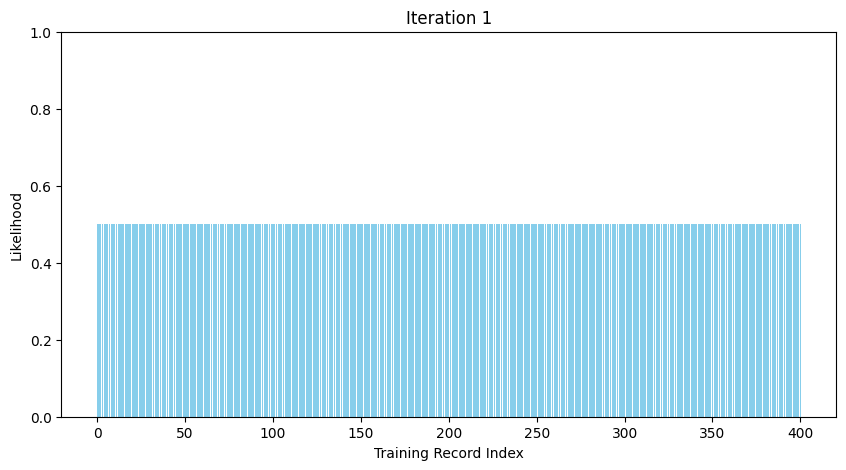

In [ ]:
iterations = len(likelihood_iterations_per_sample)
likelihood_size = likelihood_iterations_per_sample[0].size

xaxis = np.arange(likelihood_size)

fig,ax = plt.subplots(figsize=(10,5))
bars = ax.bar(xaxis,likelihood_iterations_per_sample[0],color="skyblue")
ax.set_ylim(0,1)
ax.set_xlabel("Training Record Index")
ax.set_ylabel("Likelihood")
ax.set_title("Likelihood Evolution per Sample")
def update(frame):
    for bar, new_height in zip(bars, likelihood_iterations_per_sample[frame]):
        bar.set_height(new_height)
    ax.set_title(f"Iteration {frame+1}")
    return bars

anim = FuncAnimation(fig, update, frames=iterations, interval=500, blit=False, repeat=True)
plt.show()
HTML(anim.to_jshtml())

In [37]:
#Cross Entropy
def cross_entropy(likelihood_vector):
    return -np.sum(np.log(likelihood_vector))

ce_train = [cross_entropy(l) for l in likelihood_v_folds_train]
ce_val = [cross_entropy(l) for l in likelihood_v_folds_val]
ce_test = [cross_entropy(l) for l in likelihood_v_folds_test]

ce_train_expected = cross_entropy(likelihood_v_train_expected)
ce_test_expected = cross_entropy(likelihood_v_test_expected)



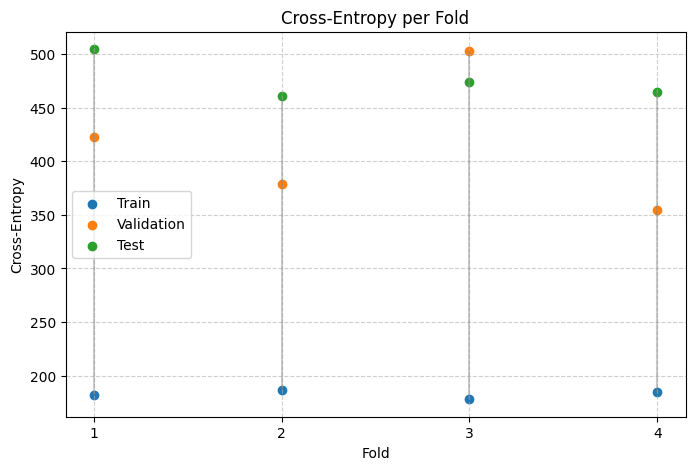

In [38]:
#Plot Folds vs Cross Entropy of Train Validation and Test



folds = np.arange(1, len(ce_train) + 1)
plt.figure(figsize=(8,5))

for i, fold in enumerate(folds):
    plt.vlines(fold, min(ce_train[i], ce_val[i], ce_test[i]),
                      max(ce_train[i], ce_val[i], ce_test[i]),
               color='gray', alpha=0.4)
    plt.scatter(fold, ce_train[i], color='tab:blue', label='Train' if i == 0 else "")
    plt.scatter(fold, ce_val[i],   color='tab:orange', label='Validation' if i == 0 else "")
    plt.scatter(fold, ce_test[i],  color='tab:green', label='Test' if i == 0 else "")

plt.xlabel('Fold')
plt.ylabel('Cross-Entropy')
plt.title('Cross-Entropy per Fold')
plt.xticks(folds)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
# plt.tight_layout()
plt.show()

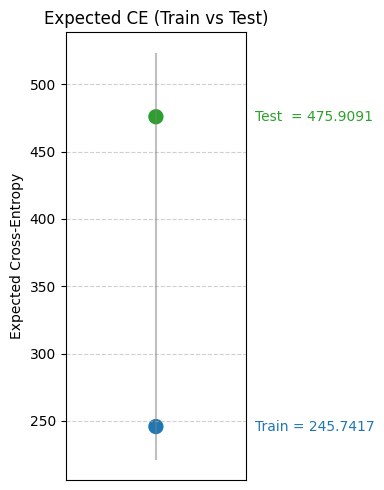

In [39]:
#Plot Expected Cross Entropy Tain and Expected Cross Entropy Test

values = [ce_train_expected, ce_test_expected]
labels = ['Train', 'Test']

plt.figure(figsize=(4, 5))

plt.vlines(1, min(values) * 0.9, max(values) * 1.1, color='gray', alpha=0.5)
plt.scatter([1, 1], values, color=['tab:blue', 'tab:green'], s=100)

plt.text(1.06, ce_train_expected, f"Train = {ce_train_expected:.4f}", va='center', color='tab:blue')
plt.text(1.06, ce_test_expected,  f"Test  = {ce_test_expected:.4f}", va='center', color='tab:green')

plt.ylabel('Expected Cross-Entropy')
plt.title('Expected CE (Train vs Test)')
plt.xticks([])
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [40]:
#ROC
def ROC(Y,P_vector):
    score = np.asarray(P_vector)
    label = np.asarray(Y)
    order = np.argsort(-score)
    label_sorted = label[order]
    score_sorted = score[order]
    
    TP_cumulative = np.cumsum(label_sorted)
    FP_cumulative = np.cumsum(1-label_sorted)


    TP_total = np.sum(label_sorted)
    FP_total = len(label_sorted)-TP_total

    thresholds, idx = np.unique(score_sorted, return_index=True)
    idx = np.sort(idx)

    TPR = np.concatenate(([0.0],TP_cumulative[idx]/TP_total))
    FPR = np.concatenate(([0.0],FP_cumulative[idx]/FP_total))

    TPR = np.append(TPR,1.0)
    FPR = np.append(FPR,1.0)

    return TPR,FPR



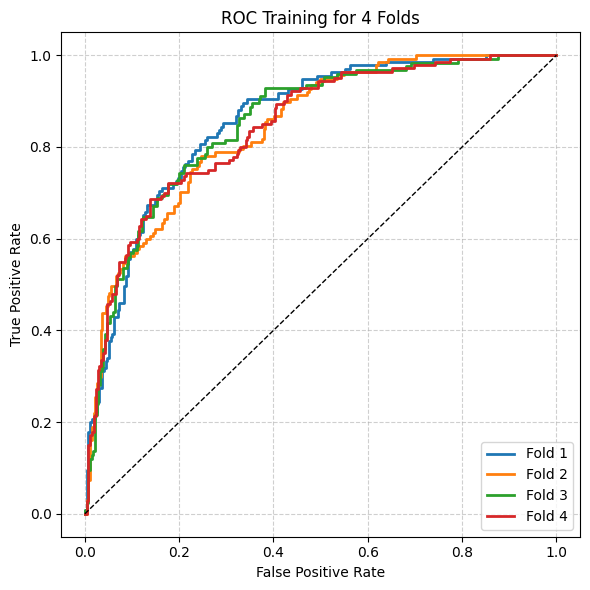

In [41]:
#Plot ROC train for 4 folds
plt.figure(figsize=(6, 6))



# Loop over each fold
for it in range(len(Y_v_folds_train)):
    Y = Y_v_folds_train[it]
    P = P_v_folds_train[it]
    
    TPR,FPR = ROC(Y, P)
    
    plt.plot(FPR, TPR, lw=2, label=f"Fold {it+1}")

# Plot the random baseline (diagonal)
plt.plot([0, 1], [0, 1], 'k--', lw=1)

# Labels and styling
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Training for 4 Folds')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



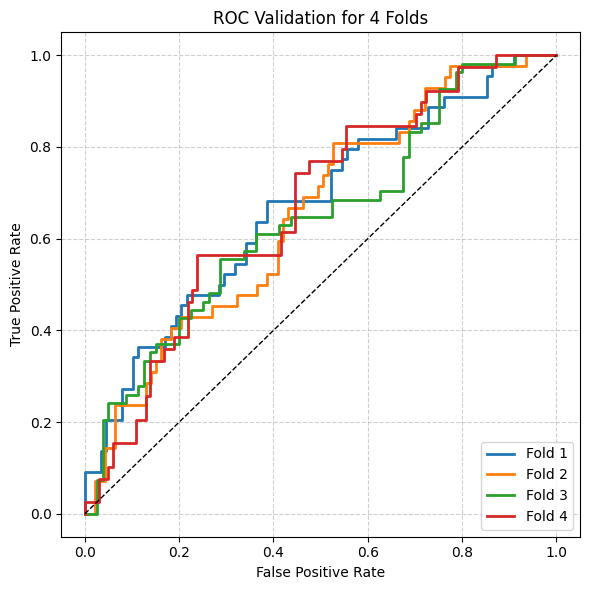

In [42]:
#Plot ROC validation for 4 folds
plt.figure(figsize=(6, 6))



# Loop over each fold
for it in range(len(Y_v_folds_val)):
    Y = Y_v_folds_val[it]
    P = P_v_folds_val[it]
    
    TPR,FPR = ROC(Y, P)
    
    plt.plot(FPR, TPR, lw=2, label=f"Fold {it+1}")

# Plot the random baseline (diagonal)
plt.plot([0, 1], [0, 1], 'k--', lw=1)

# Labels and styling
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Validation for 4 Folds')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


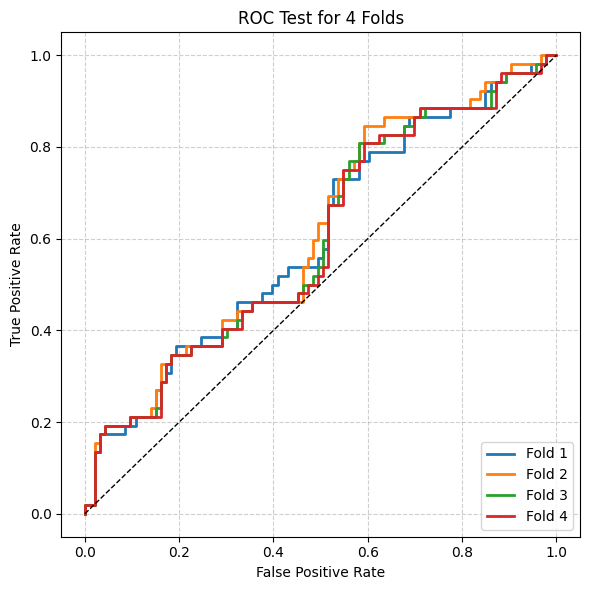

In [43]:
#Plot ROC test for 4 folds
plt.figure(figsize=(6, 6))



# Loop over each fold
for it in range(len(Y_v_folds_test)):
    Y = Y_v_folds_test[it]
    P = P_v_folds_test[it]
    
    TPR,FPR = ROC(Y, P)
    
    plt.plot(FPR, TPR, lw=2, label=f"Fold {it+1}")

# Plot the random baseline (diagonal)
plt.plot([0, 1], [0, 1], 'k--', lw=1)

# Labels and styling
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Test for 4 Folds')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

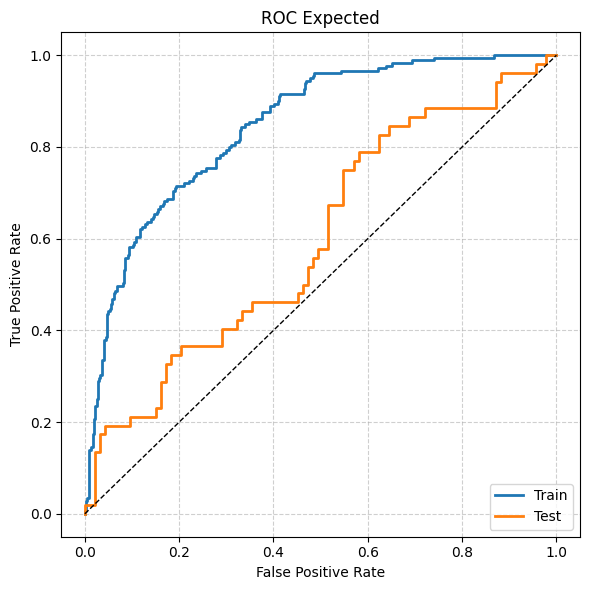

In [44]:
#Plot ROC expected for Train and Test
plt.figure(figsize=(6, 6))



# # Loop over each fold
# for it in range(len(Y_v_folds_test)):
#     Y = Y_v_folds_test[it]
#     P = P_v_folds_test[it]
    
#     TPR,FPR = ROC(Y, P)
    
#     plt.plot(FPR, TPR, lw=2, label=f"Fold {it+1}")

TPR_train,FPR_train = ROC(Y_v_train_expected,P_v_train_expected)
TPR_test,FPR_test = ROC(Y_v_test_expected,P_v_test_expected)
plt.plot(FPR_train,TPR_train,lw=2,label="Train")
plt.plot(FPR_test,TPR_test,lw=2,label="Test")

# Plot the random baseline (diagonal)
plt.plot([0, 1], [0, 1], 'k--', lw=1)

# Labels and styling
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Expected')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()